In [1]:
# -------------------------------------------
# 1️⃣ Load S&P 500 tickers & prices
# -------------------------------------------
import pandas as pd
import numpy as np
import yfinance as yf

# Get tickers from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Date range: 8 years back from end date
end_date = '2025-04-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

# Download daily OHLCV data
df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date
).stack()

# MultiIndex: [date, ticker]
df.index.names = ['date', 'ticker']

# Standardize column names
df.columns = df.columns.str.lower()

# Keep only OHLCV
df = df[['open', 'high', 'low', 'close', 'volume']]

print(df.head())


C:\Users\user\AppData\Local\Temp\ipykernel_14600\1415684757.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  502 of 502 completed
C:\Users\user\AppData\Local\Temp\ipykernel_14600\1415684757.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ).stack()


Price                   open       high        low      close      volume
date       ticker                                                        
2017-04-27 A       51.595095  52.139880  51.501168  52.064739   1529000.0
           AAPL    33.385420  33.441095  33.243917  33.355263  56985200.0
           ABBV    46.484344  47.940311  46.249973  46.924686  11692900.0
           ABT     38.138571  38.181949  37.826244  37.869625   7487300.0
           ACGL    30.932727  31.094382  30.805943  31.005630    972000.0


# Feature engineering

In [2]:
# -------------------------------------------
# 2️⃣ Technical Features: ATR, RSI, BBANDS, MACD, GK Vol
# -------------------------------------------

# ✅ Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * ((np.log(df['close']) - np.log(df['open'])) ** 2)
)

# ✅ RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['rsi'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_rsi)

# ✅ Bollinger Bands
def bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = sma + num_std * std
    lower = sma - num_std * std
    return pd.DataFrame({'bb_low': lower, 'bb_mid': sma, 'bb_up': upper})

bb = df.groupby(level=1)['close'].apply(bollinger_bands).reset_index(level=0, drop=True)
df = df.join(bb)

# ✅ ATR
def true_range(df):
    hl = df['high'] - df['low']
    hc = np.abs(df['high'] - df['close'].shift())
    lc = np.abs(df['low'] - df['close'].shift())
    return pd.concat([hl, hc, lc], axis=1).max(axis=1)

def compute_atr(df, period=14):
    tr = true_range(df)
    return tr.rolling(window=period).mean()

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# ✅ MACD
def compute_macd(series, short=12, long=26):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    return ema_short - ema_long

df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

# ✅ Dollar Volume
df['dollar_volume'] = df['close'] * df['volume'] / 1e6



In [3]:
df

open        high         low       close      volume  \
date       ticker                                                               
2017-04-27 A        51.595095   52.139880   51.501168   52.064739   1529000.0   
           AAPL     33.385420   33.441095   33.243917   33.355263  56985200.0   
           ABBV     46.484344   47.940311   46.249973   46.924686  11692900.0   
           ABT      38.138571   38.181949   37.826244   37.869625   7487300.0   
           ACGL     30.932727   31.094382   30.805943   31.005630    972000.0   
...                       ...         ...         ...         ...         ...   
2025-04-25 XYL     115.251932  116.019478  114.374729  115.730400   1923100.0   
           YUM     146.640683  148.073656  145.605766  146.580978   1770400.0   
           ZBH     101.167657  102.364550  100.130346  101.247452   1662000.0   
           ZBRA    243.190002  247.960007  241.470001  246.240005    530200.0   
           ZTS     152.050003  153.919998  150.500000  153.470001   3543600.0   

                   garman_klass_vol        rsi      bb_low      bb_mid  \
date       ticker                                                        
2017-04-27 A               0.000044        NaN         NaN         NaN   
           AAPL            0.000017        NaN         NaN         NaN   
           ABBV            0.000610        NaN         NaN         NaN   
           ABT             0.000024        NaN         NaN         NaN   
           ACGL            0.000041        NaN         NaN         NaN   
...                             ...        ...         ...         ...   
2025-04-25 XYL             0.000095  72.513704  100.718639  111.191898   
           YUM             0.000141  48.995846  134.923818  147.525341   
           ZBH             0.000243  35.388490   91.786732  103.527534   
           ZBRA            0.000292  60.647753  193.474066  240.550501   
           ZTS             0.000219  52.767909  140.114018  152.463154   

                        bb_up        atr       macd  dollar_volume  
date       ticker                                                   
2017-04-27 A              NaN        NaN   0.000000      79.606986  
           AAPL           NaN        NaN   0.000000    1900.756319  
           ABBV           NaN        NaN   0.000000     548.685666  
           ABT            NaN        NaN   0.000000     283.541244  
           ACGL           NaN        NaN   0.000000      30.137473  
...                       ...        ...        ...            ...  
2025-04-25 XYL     121.665157   4.317639  -1.773681     222.561132  
           YUM     160.126864   4.487272  -2.015167     259.506964  
           ZBH     115.268336   3.707528  -2.406990     168.273265  
           ZBRA    287.626937  14.817858 -13.415407     130.556451  
           ZTS     164.812289   6.106841  -2.860802     543.836296  

[988562 rows x 13 columns]

In [4]:
# -------------------------------------------
# 3️⃣ Load & join Fama-French factors
# -------------------------------------------
import pandas_datareader.data as web

# Get Fama-French 5-Factor data
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2016')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

# Compute monthly mean stock return
def calculate_returns(df):
    outlier_cutoff = 0.005
    lag = 1
    df['return_1m'] = (
        df['close']
        .pct_change(lag)
        .pipe(lambda x: x.clip(
            lower=x.quantile(outlier_cutoff),
            upper=x.quantile(1 - outlier_cutoff)
        ))
    )
    return df

df = df.groupby(level=1, group_keys=False).apply(calculate_returns)

monthly_mean_return = (
    df['return_1m']
    .reset_index()
    .groupby('date')['return_1m']
    .mean()
)

monthly_mean_return.index = monthly_mean_return.index.to_period('M').to_timestamp('M')

# Clip factor window
factor_data = factor_data.loc[monthly_mean_return.index.min():]

# Safe join
if 'mean_stock_return' in factor_data.columns:
    factor_data = factor_data.drop(columns=['mean_stock_return'])

factor_data = factor_data.join(monthly_mean_return.rename('mean_stock_return')).sort_index()

print(factor_data.head())


C:\Users\user\AppData\Local\Temp\ipykernel_14600\3543013726.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2016')[0].drop('RF', axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_14600\3543013726.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2016')[0].drop('RF', axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_14600\3543013726.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  factor_data = factor_data.resample('M').last().div(100)


            Mkt-RF     SMB     HML     RMW     CMA  mean_stock_return
date                                                                 
2017-04-30  0.0108  0.0041 -0.0205  0.0179 -0.0160                NaN
2017-04-30  0.0108  0.0041 -0.0205  0.0179 -0.0160          -0.004195
2017-05-31  0.0107 -0.0299 -0.0382  0.0099 -0.0166           0.001148
2017-05-31  0.0107 -0.0299 -0.0382  0.0099 -0.0166           0.001040
2017-05-31  0.0107 -0.0299 -0.0382  0.0099 -0.0166          -0.002874


In [5]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA,mean_stock_return
date,,,,,,
2017-04-30,0.0108,0.0041,-0.0205,0.0179,-0.0160,NaN
2017-04-30,0.0108,0.0041,-0.0205,0.0179,-0.0160,-0.004195
2017-05-31,0.0107,-0.0299,-0.0382,0.0099,-0.0166,0.001148
2017-05-31,0.0107,-0.0299,-0.0382,0.0099,-0.0166,0.001040
2017-05-31,0.0107,-0.0299,-0.0382,0.0099,-0.0166,-0.002874
...,...,...,...,...,...,...
2025-04-30,-0.0085,-0.0185,-0.0341,-0.0284,-0.0267,-0.020367
2025-04-30,-0.0085,-0.0185,-0.0341,-0.0284,-0.0267,0.025353
2025-04-30,-0.0085,-0.0185,-0.0341,-0.0284,-0.0267,0.010228


# Rolling Betas

In [6]:
# -------------------------------------------
# 4️⃣ Rolling OLS betas (Pure NumPy)
# -------------------------------------------
Y = factor_data['mean_stock_return'].values
X = factor_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values
X = np.column_stack([np.ones(len(X)), X])  # Add intercept

def rolling_ols_numpy(Y, X, window=12):
    betas = []
    for i in range(window, len(Y)):
        y_window = Y[i - window:i]
        X_window = X[i - window:i]

        beta, _, _, _ = np.linalg.lstsq(X_window, y_window, rcond=None)
        betas.append(beta)

    betas = np.array(betas)
    index = factor_data.index[window:]
    columns = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    return pd.DataFrame(betas, index=index, columns=columns)

rolling_betas = rolling_ols_numpy(Y, X, window=12)
print(rolling_betas.head())


               const    Mkt-RF       SMB       HML       RMW       CMA
date                                                                  
2017-05-31       NaN       NaN       NaN       NaN       NaN       NaN
2017-05-31 -0.004475 -0.000370 -0.109349 -0.056824 -0.025805 -0.001858
2017-05-31  0.000583  0.000006 -0.000017 -0.000022  0.000006 -0.000010
2017-05-31 -0.000880 -0.000009  0.000026  0.000034 -0.000009  0.000015
2017-05-31 -0.000697 -0.000007  0.000021  0.000027 -0.000007  0.000012


In [7]:
rolling_betas

,const,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,
2017-05-31,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-31,-0.004475,-0.000370,-0.109349,-0.056824,-0.025805,-0.001858
2017-05-31,0.000583,0.000006,-0.000017,-0.000022,0.000006,-0.000010
2017-05-31,-0.000880,-0.000009,0.000026,0.000034,-0.000009,0.000015
2017-05-31,-0.000697,-0.000007,0.000021,0.000027,-0.000007,0.000012
...,...,...,...,...,...,...
2025-04-30,-0.004912,0.000042,0.000091,0.000168,0.000140,0.000131
2025-04-30,-0.007360,0.000063,0.000136,0.000251,0.000209,0.000197
2025-04-30,-0.001924,0.000016,0.000036,0.000066,0.000055,0.000051


# Merging of all the metrics

In [8]:
# -------------------------------------------
# 5️⃣ Merge rolling betas into daily factor panel
# -------------------------------------------
df = df.reset_index()
rolling_betas = rolling_betas.reset_index().rename(columns={'index': 'date'})

df['date'] = pd.to_datetime(df['date'])
rolling_betas['date'] = pd.to_datetime(rolling_betas['date'])

df = df.sort_values('date')
rolling_betas = rolling_betas.sort_values('date')

df = pd.merge_asof(df, rolling_betas, on='date', direction='backward')
df = df.set_index(['date', 'ticker']).sort_index()

print(df.head())


                        open       high        low      close      volume  \
date       ticker                                                           
2017-04-27 A       51.595095  52.139880  51.501168  52.064739   1529000.0   
           AAPL    33.385420  33.441095  33.243917  33.355263  56985200.0   
           ABBV    46.484344  47.940311  46.249973  46.924686  11692900.0   
           ABT     38.138571  38.181949  37.826244  37.869625   7487300.0   
           ACGL    30.932727  31.094382  30.805943  31.005630    972000.0   

                   garman_klass_vol  rsi  bb_low  bb_mid  bb_up  atr  macd  \
date       ticker                                                            
2017-04-27 A               0.000044  NaN     NaN     NaN    NaN  NaN   0.0   
           AAPL            0.000017  NaN     NaN     NaN    NaN  NaN   0.0   
           ABBV            0.000610  NaN     NaN     NaN    NaN  NaN   0.0   
           ABT             0.000024  NaN     NaN     NaN    NaN  NaN  

In [9]:
df

open        high         low       close      volume  \
date       ticker                                                               
2017-04-27 A        51.595095   52.139880   51.501168   52.064739   1529000.0   
           AAPL     33.385420   33.441095   33.243917   33.355263  56985200.0   
           ABBV     46.484344   47.940311   46.249973   46.924686  11692900.0   
           ABT      38.138571   38.181949   37.826244   37.869625   7487300.0   
           ACGL     30.932727   31.094382   30.805943   31.005630    972000.0   
...                       ...         ...         ...         ...         ...   
2025-04-25 XYL     115.251932  116.019478  114.374729  115.730400   1923100.0   
           YUM     146.640683  148.073656  145.605766  146.580978   1770400.0   
           ZBH     101.167657  102.364550  100.130346  101.247452   1662000.0   
           ZBRA    243.190002  247.960007  241.470001  246.240005    530200.0   
           ZTS     152.050003  153.919998  150.500000  153.470001   3543600.0   

                   garman_klass_vol        rsi      bb_low      bb_mid  \
date       ticker                                                        
2017-04-27 A               0.000044        NaN         NaN         NaN   
           AAPL            0.000017        NaN         NaN         NaN   
           ABBV            0.000610        NaN         NaN         NaN   
           ABT             0.000024        NaN         NaN         NaN   
           ACGL            0.000041        NaN         NaN         NaN   
...                             ...        ...         ...         ...   
2025-04-25 XYL             0.000095  72.513704  100.718639  111.191898   
           YUM             0.000141  48.995846  134.923818  147.525341   
           ZBH             0.000243  35.388490   91.786732  103.527534   
           ZBRA            0.000292  60.647753  193.474066  240.550501   
           ZTS             0.000219  52.767909  140.114018  152.463154   

                        bb_up        atr       macd  dollar_volume  return_1m  \
date       ticker                                                               
2017-04-27 A              NaN        NaN   0.000000      79.606986        NaN   
           AAPL           NaN        NaN   0.000000    1900.756319        NaN   
           ABBV           NaN        NaN   0.000000     548.685666        NaN   
           ABT            NaN        NaN   0.000000     283.541244        NaN   
           ACGL           NaN        NaN   0.000000      30.137473        NaN   
...                       ...        ...        ...            ...        ...   
2025-04-25 XYL     121.665157   4.317639  -1.773681     222.561132   0.004238   
           YUM     160.126864   4.487272  -2.015167     259.506964  -0.001897   
           ZBH     115.268336   3.707528  -2.406990     168.273265   0.000099   
           ZBRA    287.626937  14.817858 -13.415407     130.556451   0.008850   
           ZTS     164.812289   6.106841  -2.860802     543.836296   0.007682   

                     const    Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                             
2017-04-27 A           NaN       NaN       NaN       NaN       NaN       NaN  
           AAPL        NaN       NaN       NaN       NaN       NaN       NaN  
           ABBV        NaN       NaN       NaN       NaN       NaN       NaN  
           ABT         NaN       NaN       NaN       NaN       NaN       NaN  
           ACGL        NaN       NaN       NaN       NaN       NaN       NaN  
...                    ...       ...       ...       ...       ...       ...  
2025-04-25 XYL    -0.00477  0.050747 -0.043747  0.025465 -0.013093  0.044987  
           YUM    -0.00477  0.050747 -0.043747  0.025465 -0.013093  0.044987  
           ZBH    -0.00477  0.050747 -0.043747  0.025465 -0.013093  0.044987  
           ZBRA   -0.00477  0.050747 -0.043747  0.025465 -0.013093  0.044987  
      

# Machine Learning Algorithm

In [10]:
# -------------------------------------------
# 6️⃣ Monthly clustering with KMeans
# -------------------------------------------
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['atr', 'macd', 'rsi', 'bb_mid', 'Mkt-RF', 'SMB', 'HML']

def get_clusters(group):
    X = group[features].values
    X_scaled = StandardScaler().fit_transform(X)
    kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    group = group.copy()
    group['cluster'] = labels
    return group

df = df.dropna(subset=features)
df = df.groupby('date', group_keys=False).apply(get_clusters)

print(df[['cluster']].head())


                   cluster
date       ticker         
2017-05-31 A             0
           AAPL          2
           ABBV          2
           ABT           0
           ACGL          0


In [11]:
df[['cluster']]

cluster
date       ticker         
2017-05-31 A             0
           AAPL          2
           ABBV          2
           ABT           0
           ACGL          0
...                    ...
2025-04-25 XYL           0
           YUM           1
           ZBH           1
           ZBRA          2
           ZTS           1

[977073 rows x 1 columns]

In [12]:
import matplotlib.pyplot as plt

def plot_clusters(data, x_feature='atr', y_feature='macd'):
    """
    Scatter plot of clusters using any two chosen features.
    """
    plt.figure(figsize=(10, 6))

    for cluster_label in sorted(data['cluster'].unique()):
        cluster_data = data[data['cluster'] == cluster_label]
        plt.scatter(
            cluster_data[x_feature],
            cluster_data[y_feature],
            label=f'Cluster {cluster_label}',
            alpha=0.6
        )

    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f'K-Means Clusters: {x_feature} vs {y_feature}')
    plt.legend()
    plt.show()


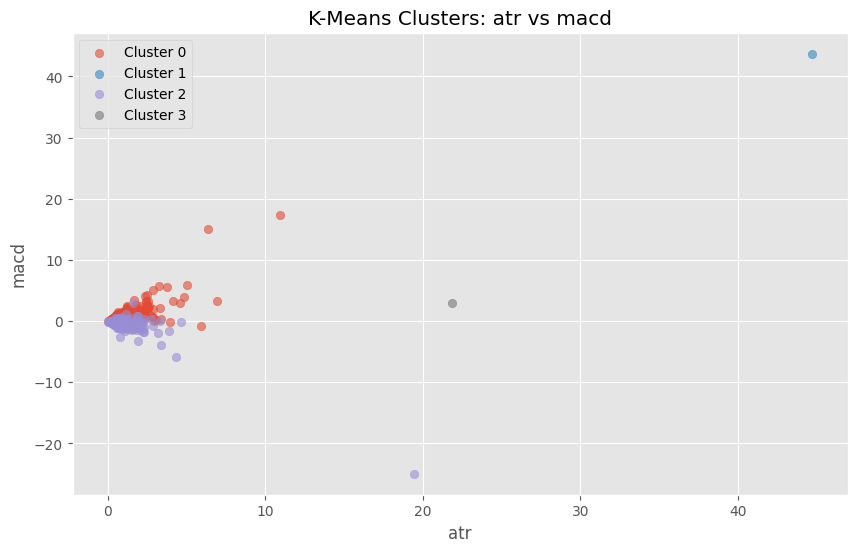

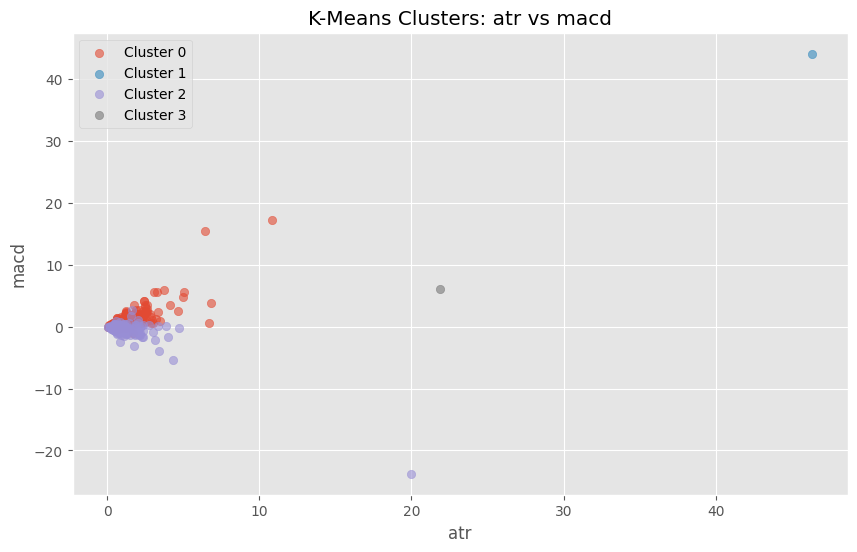

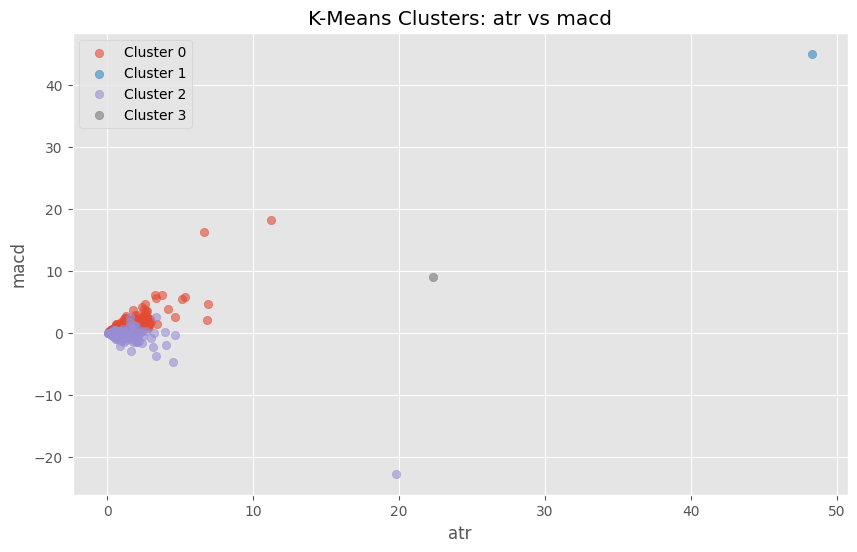

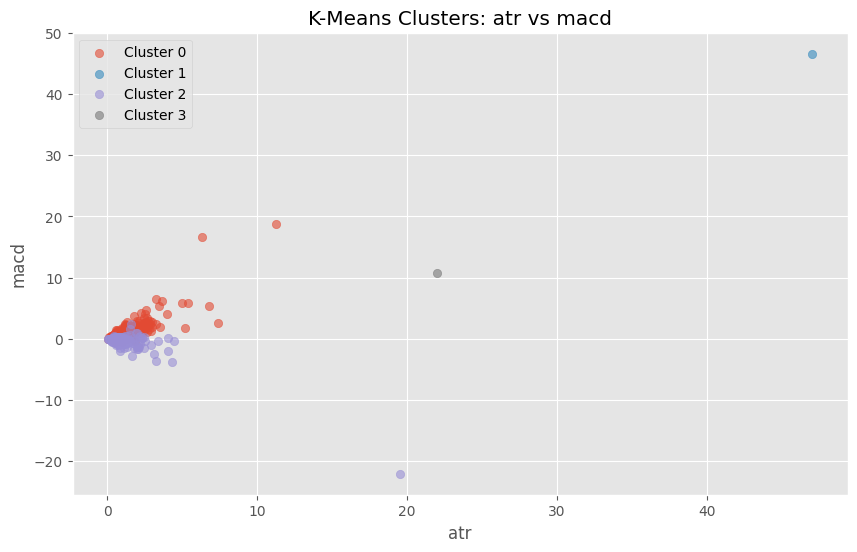

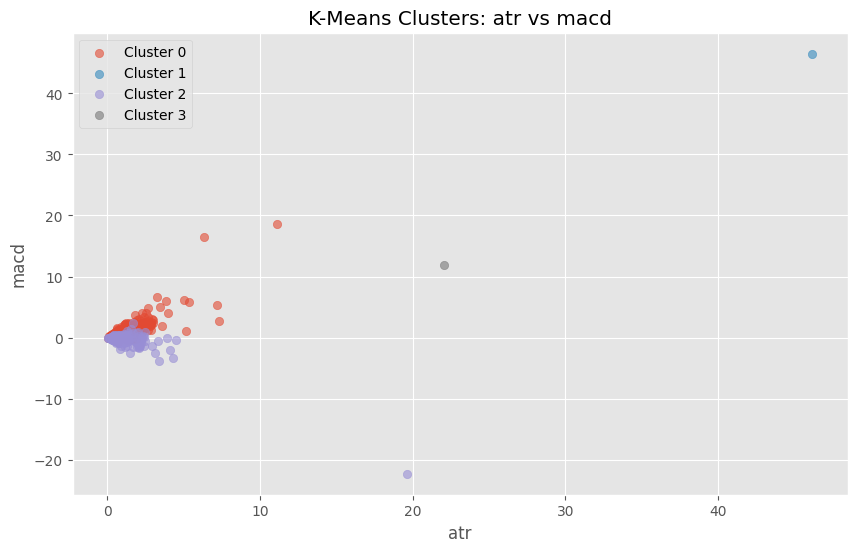

In [13]:
# ✅ Always set style once
plt.style.use('ggplot')

# ✅ Pick features you want to scatter
x_feature = 'atr'
y_feature = 'macd'

# ✅ Loop safely — use .unique()
unique_dates = df.index.get_level_values('date').unique().tolist()

# ✅ Optional: limit to first 5 for testing
for i in unique_dates[:5]:
    g = df.xs(i, level=0)  # cross-section at date i

    plot_clusters(g, x_feature=x_feature, y_feature=y_feature)


# First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

# Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:

# Pick cluster 3
cluster_id = 3
filtered_df = df[df['cluster'] == cluster_id].copy()

# Move signal date forward by 1 month (common convention)
filtered_df = filtered_df.reset_index(level=1)  # ticker becomes column
filtered_df.index = filtered_df.index + pd.DateOffset(months=1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

print(filtered_df.head())

                          open         high          low        close  \
date       ticker                                                       
2017-06-30 BKNG    1839.063801  1853.589600  1826.838789  1853.589600   
2017-07-01 BKNG    1854.735250  1871.048447  1847.013206  1867.147827   
2017-07-02 BKNG    1875.264906  1878.187809  1857.470489  1872.223389   
2017-07-05 BKNG    1866.051366  1876.459447  1865.241685  1867.897949   
2017-07-06 BKNG    1865.291304  1885.021265  1863.276925  1866.199829   

                     volume  garman_klass_vol        rsi       bb_low  \
date       ticker                                                       
2017-06-30 BKNG    560900.0          0.000082  65.800933  1749.288682   
2017-07-01 BKNG    433800.0          0.000066  72.983049  1748.669184   
2017-07-02 BKNG    463300.0          0.000060  73.066404  1750.067929   
2017-07-05 BKNG    327600.0          0.000018  73.061905  1751.117510   
2017-07-06 BKNG    459600.0          0.000067  69.

In [15]:
dates = filtered_df.index.get_level_values('date').unique()

fixed_dates = {
    d.strftime('%Y-%m-%d'): filtered_df.xs(d, level=0).index.tolist()
    for d in dates
}

print(fixed_dates)

{'2017-06-30': ['BKNG'], '2017-07-01': ['BKNG'], '2017-07-02': ['BKNG'], '2017-07-05': ['BKNG'], '2017-07-06': ['BKNG'], '2017-07-07': ['BKNG'], '2017-07-08': ['BKNG'], '2017-07-09': ['BKNG'], '2017-07-12': ['BKNG'], '2017-07-13': ['BKNG'], '2017-07-14': ['BKNG'], '2017-07-15': ['BKNG'], '2017-07-16': ['BKNG'], '2017-07-19': ['A', 'AAPL', 'ACGL', 'ADBE', 'ADI', 'ADM', 'ADSK', 'AEP', 'AES', 'AIG', 'ALB', 'AMAT', 'AMD', 'AMT', 'AMZN', 'ANSS', 'APD', 'APTV', 'AVGO', 'BAX', 'BBY', 'BF-B', 'BG', 'BKR', 'BMY', 'BR', 'BX', 'CAG', 'CCI', 'CDNS', 'CF', 'CHTR', 'CL', 'CMCSA', 'CMG', 'CMS', 'CNP', 'COP', 'COST', 'CPAY', 'CPB', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTRA', 'CVS', 'CZR', 'D', 'DECK', 'DELL', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DVA', 'DVN', 'EA', 'EBAY', 'ENPH', 'EOG', 'EPAM', 'EQIX', 'EQT', 'ETN', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FI', 'FIS', 'FRT', 'FSLR', 'FTNT', 'GD', 'GDDY', 'GEN', 'GILD', 'GIS', 'GLW', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GRMN', 'HAL', 'HES', 'HII', 

# Define portfolio optimization function
- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()


# Download Fresh Daily Prices Data only for short listed stocks.

In [19]:
stocks = df.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(
    tickers=stocks,
    start=df.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
    end=df.index.get_level_values('date').unique()[-1]
)

new_df

C:\Users\user\AppData\Local\Temp\ipykernel_14600\376771594.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_df = yf.download(
[*********************100%***********************]  502 of 502 completed


Price            Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2016-05-31   42.654465   22.823275   43.034184         NaN   33.532593   
2016-06-01   42.710232   22.503307   42.965809         NaN   33.422596   
2016-06-02   42.663765   22.334175   44.511284         NaN   33.447975   
2016-06-03   42.496437   22.379885   44.449730         NaN   33.151833   
2016-06-06   42.626568   22.542156   42.958958         NaN   33.143364   
...                ...         ...         ...         ...         ...   
2025-04-17  102.264641  196.722031  172.990005  112.699997  130.979996   
2025-04-21  100.049301  192.907028  170.160004  111.610001  129.889999   
2025-04-22  102.593941  199.478424  173.779999  114.910004  131.729996   
2025-04-23  104.779335  204.332062  177.050003  118.279999  129.839996   
2025-04-24  106.795090  208.097107  180.369995  121.709999  129.380005   

Price                                                                 ...  \
Ticker           ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                  ...   
2016-05-31  23.030762  103.077858   99.470001   49.118340  32.837818  ...   
2016-06-01  22.983217  103.112511  100.040001   49.244286  32.883892  ...   
2016-06-02  23.033932  103.311798  100.169998   48.933632  33.375275  ...   
2016-06-03  22.865940  103.017204   98.699997   48.790890  33.475075  ...   
2016-06-06  22.723307  103.623680   99.120003   47.934467  33.528820  ...   
...               ...         ...         ...         ...        ...  ...   
2025-04-17  92.570000  282.350006  348.799988  175.471085  47.333790  ...   
2025-04-21  89.790001  279.230011  343.220001  174.196884  47.601048  ...   
2025-04-22  92.949997  283.959991  349.910004  177.690979  48.046471  ...   
2025-04-23  92.510002  288.160004  351.959991  182.280090  47.630741  ...   
2025-04-24  92.099998  291.410004  360.910004  194.345154  48.284031  ...   

Price        Volume                                                         \
Ticker          WTW       WY     WYNN      XEL       XOM      XYL      YUM   
Date                                                                         
2016-05-31  1384200  6074300  2139100  4784400  13178800  1256400  6090354   
2016-06-01   441500  3096300  2100500  2541600   7994800   995300  3609923   
2016-06-02   423600  3071100  2985400  2222700   9837500  1007100  2827903   
2016-06-03   496700  3489400  2769200  2656800   9367100  1278000  1848083   
2016-06-06   536700  3913200  2323200  2238900   8573000  1002200  2479040   
...             ...      ...      ...      ...       ...      ...      ...   
2025-04-17   658700  2651600  1559500  2784500  17835400  2154900  1768300   
2025-04-21   655900  2828300  2525900  5664900  16926500  1917900  1708200   
2025-04-22   643000  2950100  2560300  5162400  13147000  2416300  1670800   
2025-04-23   922800  2427100  2810500  5639000  14235700  1773200  2301000   
2025-04-24  1402000  4047800  1937000  6499700   9849600  1819200  2079800   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2016-05-31  2089767  546800  2804200  
2016-06-01   981590  606800  2140700  
2016-06-02   888066  429200  1750900  
2016-06-03  1284204  604300  2287000  
2016-06-06  2185351  530900  2006600  
...             ...     ...      ...  
2025-04-17  4367900  391100  4239800  
2025-04-21  2324000  443400  2654900  
2025-04-22  1428200  582600  2832800  
2025-04-23  1607000  507400  2093100  
2025-04-24  1972300  411100  2147400  

[2239 rows x 2510 columns]

# Checklist:
- Calculate daily returns for each stock which could land up in our portfolio.
- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
- Calculated each day portfolio return.

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

def optimize_weights(prices, lower_bound=0.0):
    returns = expected_returns.mean_historical_return(prices, frequency=252)
    cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
    ef = EfficientFrontier(returns, cov, weight_bounds=(lower_bound, 1.0), solver="SCS")
    weights = ef.max_sharpe()
    return ef.clean_weights()

returns_dataframe = np.log(new_df['Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        start_date_pd = pd.to_datetime(start_date)
        optimization_start_date = (start_date_pd - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (start_date_pd - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        end_date = (start_date_pd + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        tickers = fixed_dates[start_date]

        price_window = new_df['Close'].loc[optimization_start_date:optimization_end_date, tickers]
        price_window = price_window.ffill().bfill()
        price_window = price_window.dropna(axis=1, thresh=int(0.9 * len(price_window)))
        valid_tickers = [t for t in price_window.columns if price_window[t].dropna().shape[0] >= 180]

        if len(valid_tickers) < 2:
            # Quiet: skip print
            weights = pd.DataFrame([1 / len(tickers) for _ in tickers]).T
            weights.columns = tickers
        else:
            price_window = price_window[valid_tickers]
            try:
                weights = optimize_weights(prices=price_window)
                weights = pd.DataFrame([weights], columns=price_window.columns)
                print(f"✅ Optimized portfolio for {start_date} with {len(price_window.columns)} tickers.")
            except Exception:
                # Quiet fallback
                weights = pd.DataFrame([1 / len(price_window.columns) for _ in price_window.columns]).T
                weights.columns = price_window.columns

        period_returns = returns_dataframe.loc[start_date:end_date, tickers]
        tidy_returns = period_returns.stack().reset_index()
        tidy_returns.columns = ['date', 'ticker', 'return']

        tidy_weights = weights.T.reset_index()
        tidy_weights.columns = ['ticker', 'weight']

        tidy_returns = tidy_returns.merge(tidy_weights, on='ticker', how='left')
        tidy_returns['weighted_return'] = tidy_returns['return'] * tidy_returns['weight']

        daily_portfolio_return = tidy_returns.groupby('date')['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, daily_portfolio_return])

    except Exception as loop_err:
        print(f"⚠️ Loop failed for {start_date}: {loop_err}")

portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]
portfolio_df


✅ Optimized portfolio for 2017-07-19 with 220 tickers.
✅ Optimized portfolio for 2017-07-23 with 151 tickers.
✅ Optimized portfolio for 2017-07-27 with 234 tickers.
✅ Optimized portfolio for 2017-07-28 with 218 tickers.
✅ Optimized portfolio for 2017-07-29 with 3 tickers.
✅ Optimized portfolio for 2017-07-30 with 246 tickers.
✅ Optimized portfolio for 2017-08-03 with 256 tickers.
✅ Optimized portfolio for 2017-08-05 with 261 tickers.
✅ Optimized portfolio for 2017-08-06 with 162 tickers.
✅ Optimized portfolio for 2017-08-10 with 229 tickers.
✅ Optimized portfolio for 2017-08-12 with 214 tickers.
✅ Optimized portfolio for 2017-08-14 with 141 tickers.
✅ Optimized portfolio for 2017-08-17 with 212 tickers.
✅ Optimized portfolio for 2017-08-18 with 171 tickers.
✅ Optimized portfolio for 2017-08-19 with 266 tickers.
✅ Optimized portfolio for 2017-08-20 with 260 tickers.
✅ Optimized portfolio for 2017-08-21 with 162 tickers.
✅ Optimized portfolio for 2017-08-27 with 196 tickers.
✅ Optimized 

,Strategy Return
date,
2017-06-30,-0.003453
2017-07-03,-0.014751
2017-07-05,0.012337
2017-07-06,0.003365
2017-07-07,0.024376
...,...
2025-04-17,0.011266
2025-04-21,-0.034197
2025-04-22,0.038594


# Portfolio vs S&P500 Return Visualization

[*********************100%***********************]  1 of 1 completed


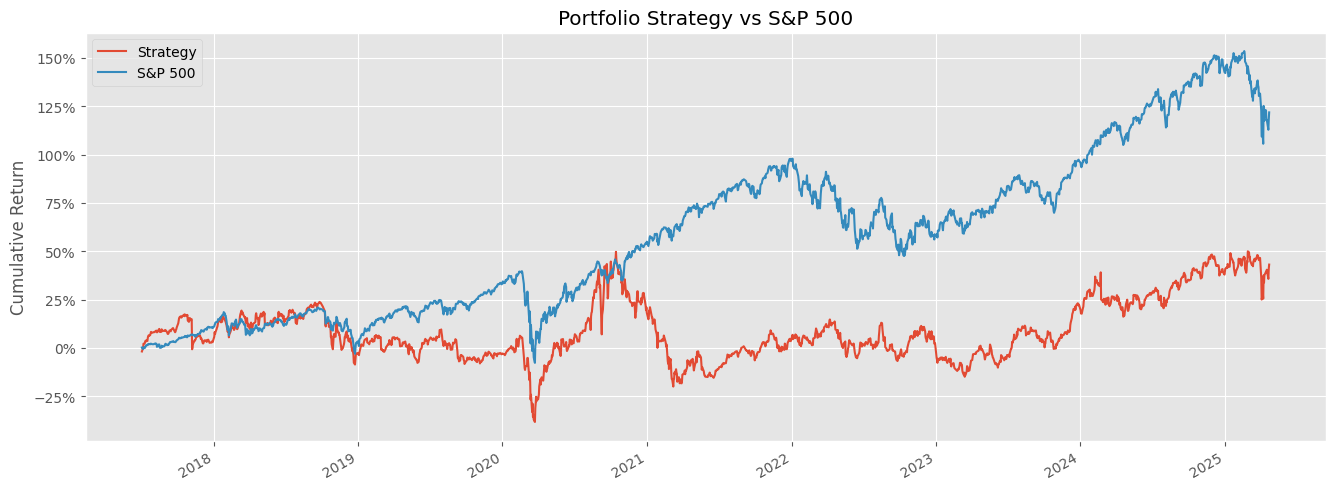

In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ✅ 1️⃣ Get S&P500 benchmark safely
sp500_raw = yf.download('^GSPC',
                        start=portfolio_df.index.min(),
                        end=portfolio_df.index.max())

# ✅ Use 'Adj Close' if it exists, else fallback to 'Close'
if 'Adj Close' in sp500_raw.columns:
    sp500 = sp500_raw['Adj Close']
else:
    sp500 = sp500_raw['Close']

# ✅ 2️⃣ Compute daily log returns & cumulative return
sp500_return = np.log(sp500).diff().dropna()
sp500_cum_return = np.exp(sp500_return.cumsum()) - 1

# ✅ 3️⃣ Portfolio cumulative return
portfolio_cum_return = np.exp(portfolio_df['Strategy Return'].cumsum()) - 1

# ✅ 4️⃣ Combine & align dates
combined = pd.concat([portfolio_cum_return, sp500_cum_return], axis=1)
combined.columns = ['Strategy', 'S&P 500']
combined = combined.dropna()

# ✅ 5️⃣ Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 6))

combined.plot(ax=ax)

# ✅ Save to file BEFORE plt.show()
plt.savefig('portfolio_vs_sp500.png', dpi=300, bbox_inches='tight')

ax.set_title('Portfolio Strategy vs S&P 500')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.show()


# Strategy Explanation
- The strategy lags the S&P 500 significantly in cumulative return — it underperforms the benchmark.
- The drawdowns are smaller than the index at some points — may have lower volatility, which is good.
- The periods when the S&P rallies strongly (e.g., 2020–2021) show my strategy doesn’t capture upside fully.
- The strategy appears more stable during crashes (COVID dip, late 2022) — indicating defensive behavior.
- The stock selection (unsupervised clusters) might be too conservative — or the equal-weight fallback dilutes alpha.
- The frequent fallback to equal weights hints my signal/optimization needs stronger data quality or constraints.
- The cluster-based selection idea is interesting — but likely needs refinement or more factors/features.
- Portfolio turnover costs aren’t shown — if my approach rebalances monthly, those could eat more returns.
- The Sharpe ratio might still be respectable if risk is low — but absolute return needs boosting.
- Overall: promising framework — but needs stronger predictive signal or smarter weight allocation to beat the index.